In [12]:
pip install scikit-plot


Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import math
import numpy as np
import pandas as pd

import cv2
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from tensorflow.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical


In [8]:
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [9]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [10]:
#Text to numerical labeling
emotions_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [11]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [13]:
#calculate the side length of the images
math.sqrt(len(df.pixels[0].split(' ')))

48.0

In [14]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

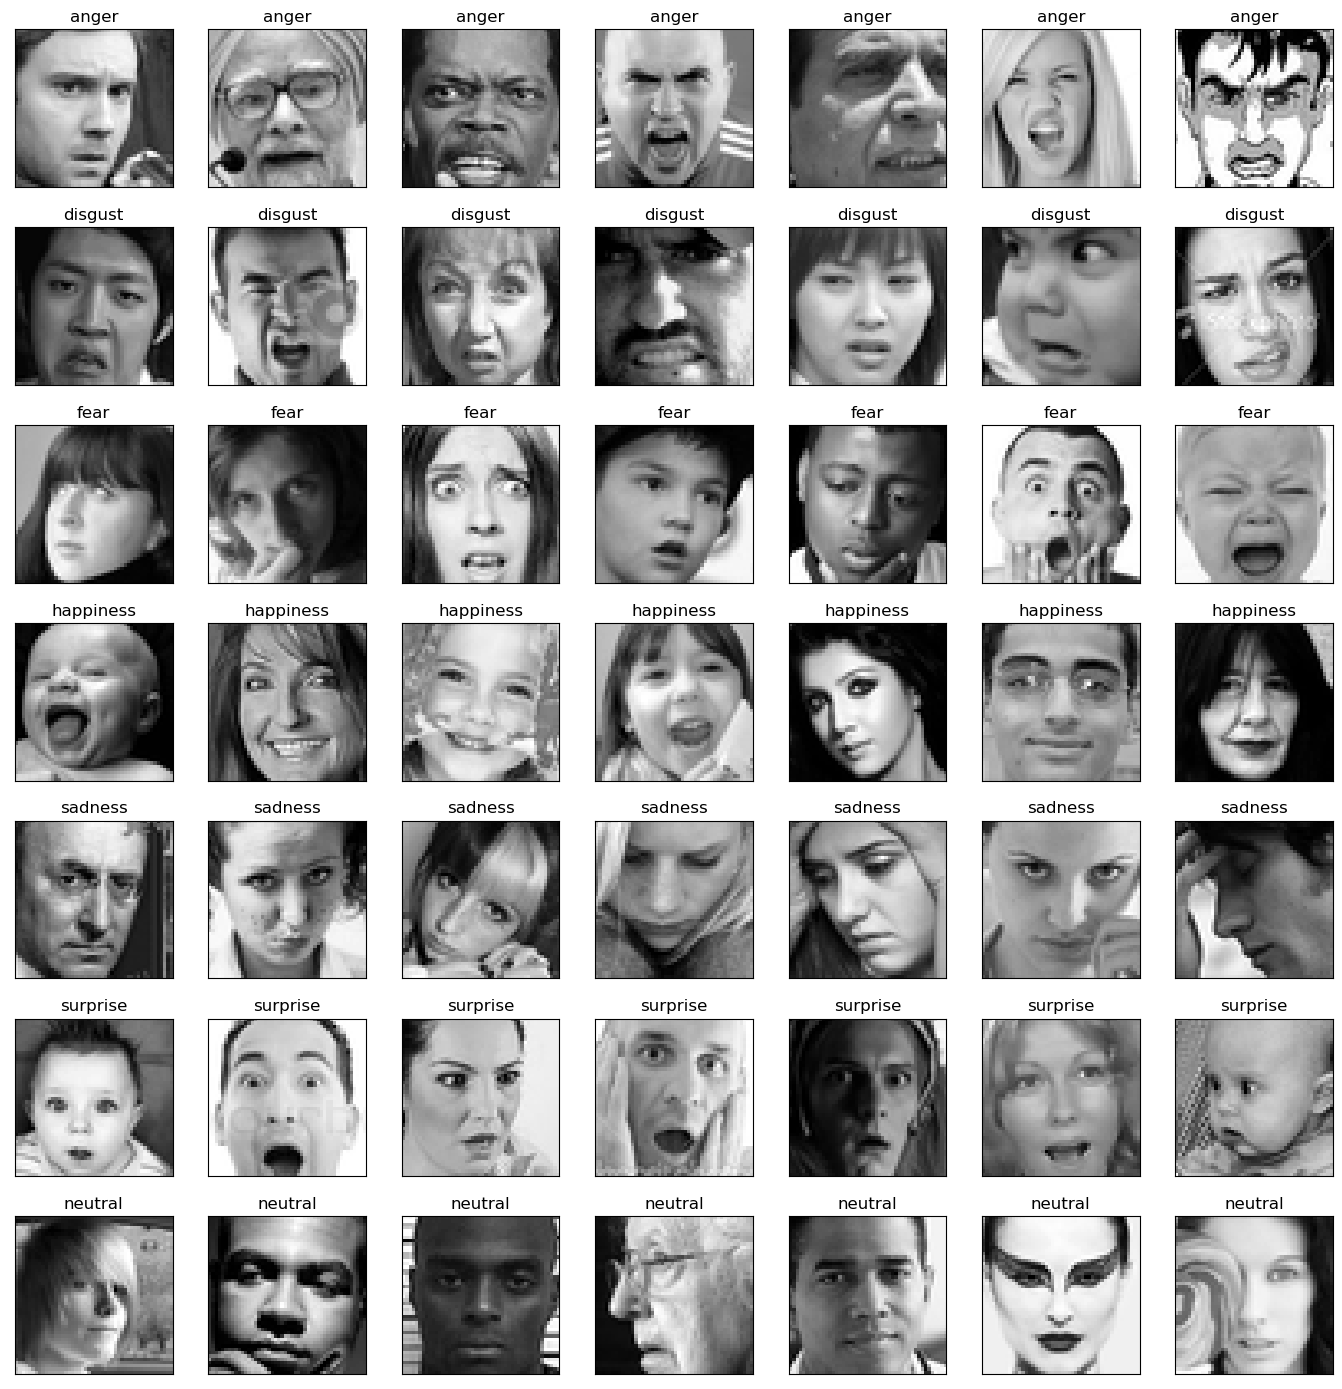

In [15]:
#Viewing the images
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions_labels[label])
        pyplot.tight_layout()

In [16]:
### To make the data ready for the neural networks

In [17]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [18]:
#Viewing the shape of image array created
img_array.shape

(35887, 48, 48)

In [19]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


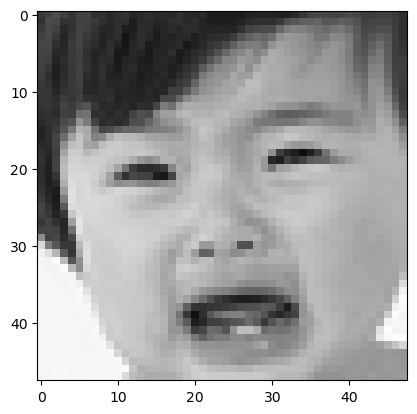

In [20]:
#Showing an image from those
pyplot.imshow(img_features[400].astype(np.uint8));

In [21]:
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [22]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [23]:
## Training the model

In [24]:
#Train and Test split of data
X_train, X_valid, y_train, y_valid = train_test_split(img_features, img_labels, shuffle = True, stratify = img_labels, test_size = 0.1, random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [25]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [26]:
## To normalise the results 

In [62]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [28]:
# Loading VGG19 convolutional neural network (CNN) from Keras
vgg19 = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False, input_shape = (48, 48, 3))

In [29]:
# Making all layers of VGG19 model non-trainable
for layer in vgg19.layers:
    layer.trainable = False

When a model is marked as non-trainable, the weights of its layers are fixed and remain unchanged during training. In other words, the model will not adjust its weights based on the current training data.

Setting the layers of the pre-trained VGG19 model to be non-trainable has the effect of using the pre-learned features of the model for the new problem at hand, without updating the model's weights based on the new data. This is called transfer learning, and it allows us to use a pre-trained model for a new task, which may have fewer training examples or a different distribution of data than the original task.

Using transfer learning with a pre-trained model like VGG19 is generally considered a good practice in deep learning, especially when the amount of data available for the new problem is limited.

By using pre-trained weights, we can take advantage of the model's ability to learn meaningful features from images, without having to train a new model from scratch. This saves time and computational resources, and can often lead to better results than training a new model with limited data.

However, the performance of the pre-trained model on the new task depends on the similarity of the new data to the data on which the model was originally trained. If the new data is very different, the pre-trained weights may not be useful, and it may be necessary to fine-tune the model's weights on the new data. In some cases, it may also be necessary to modify the architecture of the pre-trained model to better suit the new task.

In the context of facial emotion recognition using the VGG19 model, we are taking advantage of the pre-learned features of the VGG19 model for image classification, and adapting it for our specific task of recognizing facial emotions. By keeping the pre-trained weights fixed, we can use the power of transfer learning to improve the performance of our model on our specific task.

In [30]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [31]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
    
    return model

The function first takes the output of the second-to-last layer of the pre-trained model, which contains high-level features learned from the input images, and passes it through a global average pooling layer. This layer takes the average of each feature map in the input and reduces the spatial dimensions of the output to 1x1, while retaining the channel dimension.

The output of the global average pooling layer is then passed through a fully connected Dense layer with a softmax activation function, which outputs a probability distribution over the possible classes of facial emotions.

The resulting model has all layers of the pre-trained model frozen, and only the newly added layers are trainable. This is because the pre-trained weights are already optimized for a specific task (image classification on ImageNet), and we want to preserve these weights while only adjusting the new layers for the task of facial emotion recognition.

In [32]:
head = build_model(vgg19, num_classes)
model = Model(inputs = vgg19.input, outputs = head)

In [33]:
#'early stopping' for avoiding overfitting training data and `ReduceLROnPlateau` for learning rate

early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

In [34]:
#Generating more training data
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [35]:
batch_size = 32 
epochs = 25
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])


In [36]:
history = model.fit(train_datagen.flow(X_train, 
                                       y_train, 
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       verbose = 1,
                                       epochs = epochs,
                                       callbacks = callbacks)

Epoch 1/25
1010/1010 [==============================] - 20s 13ms/step - loss: 1.8362 - accuracy: 0.2266 - val_loss: 1.7577 - val_accuracy: 0.2744 - lr: 1.0000e-04
Epoch 2/25
1010/1010 [==============================] - 12s 11ms/step - loss: 1.7504 - accuracy: 0.2817 - val_loss: 1.7126 - val_accuracy: 0.3221 - lr: 1.0000e-04
Epoch 3/25
1010/1010 [==============================] - 11s 11ms/step - loss: 1.7235 - accuracy: 0.3012 - val_loss: 1.6900 - val_accuracy: 0.3305 - lr: 1.0000e-04
Epoch 4/25
1010/1010 [==============================] - 11s 11ms/step - loss: 1.7085 - accuracy: 0.3091 - val_loss: 1.6748 - val_accuracy: 0.3327 - lr: 1.0000e-04
Epoch 5/25
1010/1010 [==============================] - 11s 11ms/step - loss: 1.6980 - accuracy: 0.3161 - val_loss: 1.6626 - val_accuracy: 0.3366 - lr: 1.0000e-04
Epoch 6/25
1010/1010 [==============================] - 11s 11ms/step - loss: 1.6904 - accuracy: 0.3186 - val_loss: 1.6618 - val_accuracy: 0.3438 - lr: 1.0000e-04
Epoch 7/25
1010/1010 [

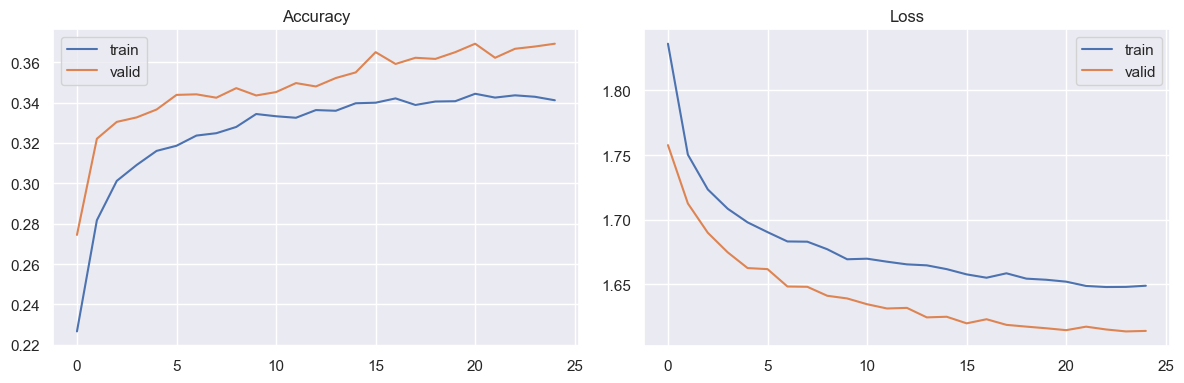

In [37]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn_VGG19_transfer_learning.png')
pyplot.show()

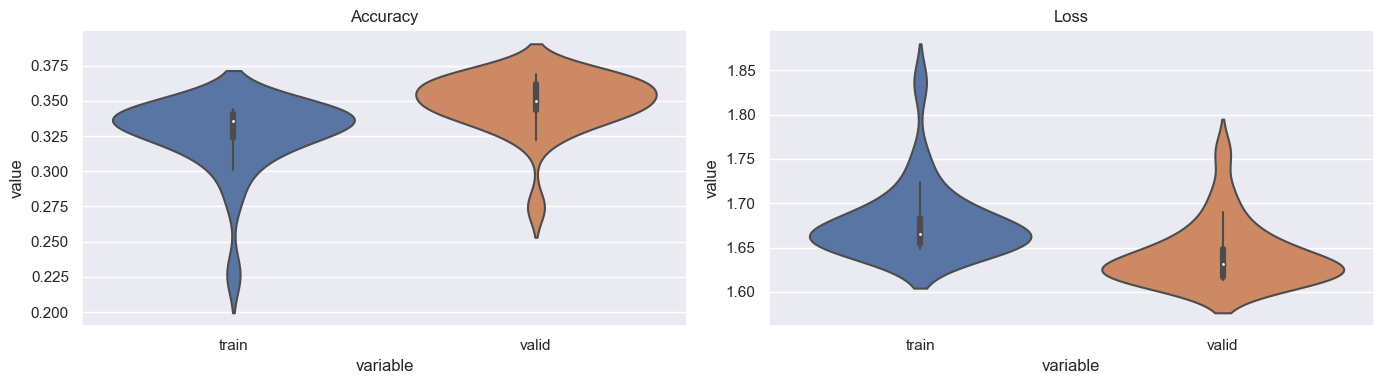

In [38]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

113/113 [==============================] - 1s 5ms/step
total wrong validation predictions: 2264


              precision    recall  f1-score   support

           0       0.32      0.08      0.13       495
           1       0.00      0.00      0.00        55
           2       0.36      0.11      0.17       512
           3       0.35      0.85      0.49       899
           4       0.41      0.12      0.19       608
           5       0.47      0.55      0.51       400
           6       0.37      0.28      0.32       620

    accuracy                           0.37      3589
   macro avg       0.33      0.28      0.26      3589
weighted avg       0.37      0.37      0.31      3589



C:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


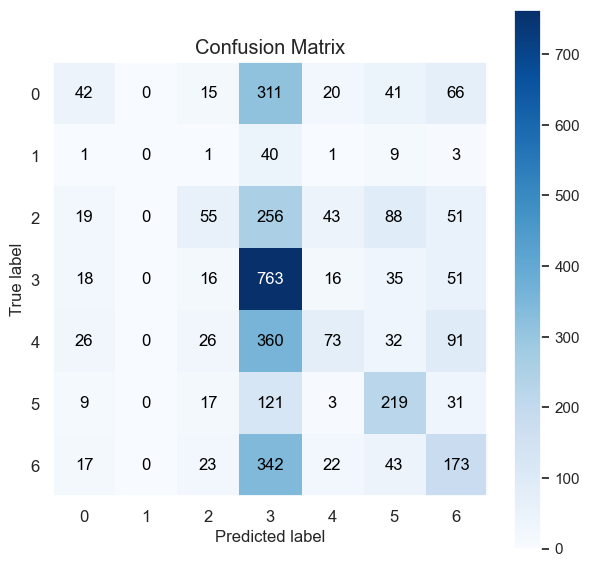

In [39]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [40]:
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

1/1 [==============================] - 0s 0s/step


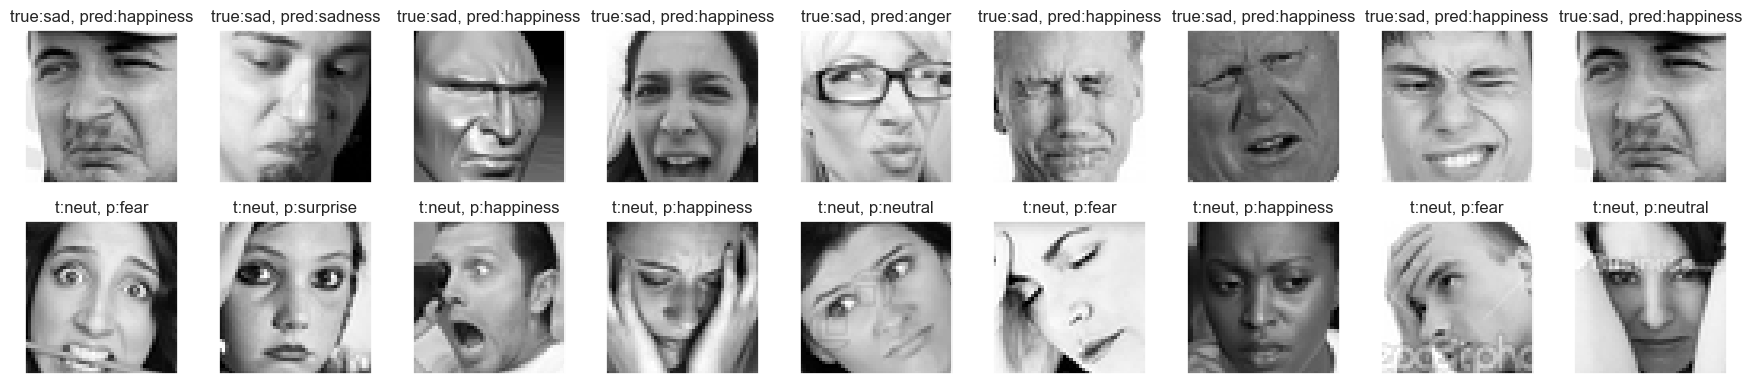

In [41]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

        ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)
        
        ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        pyplot.tight_layout()

## Evaluating the model with making vgg models  trainable

In [83]:
#Train and Test split of data
X_train, X_valid, y_train, y_valid = train_test_split(img_features, img_labels, shuffle = True, stratify = img_labels, test_size = 0.1, random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [84]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [85]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [86]:
pip install imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [87]:
print(X_train.shape)  
print(y_train.shape)  


(32298, 48, 48, 3)
(32298, 7)


In [88]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import class_weight

# Flatten the image data
num_samples, img_height, img_width, num_channels = X_train.shape
X_train_flattened = X_train.reshape(num_samples, -1)

# Transform the label data to 1D
y_train_single = np.argmax(y_train, axis=1)

# Instantiate the random undersampler
rus = RandomUnderSampler(random_state=42)

# Resample the data
X_resampled_flattened, y_resampled_single = rus.fit_resample(X_train_flattened, y_train_single)

# If needed, you can reshape the flattened image data back to its original shape
X_resampled = X_resampled_flattened.reshape(-1, img_height, img_width, num_channels)

In [89]:
from keras.preprocessing.image import ImageDataGenerator

In [90]:
import numpy as np


# Calculate the class distribution in the resampled data
unique_classes, class_counts = np.unique(y_resampled_single, return_counts=True)

# Print the class counts
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")


Class 0: 492 samples
Class 1: 492 samples
Class 2: 492 samples
Class 3: 492 samples
Class 4: 492 samples
Class 5: 492 samples
Class 6: 492 samples


In [91]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [92]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

In [93]:
# Loading VGG19 convolutional neural network (CNN) from Keras
vgg = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False, input_shape = (48, 48, 3))

In [94]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [95]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
    
    return model

In [96]:
head = build_model(vgg, num_classes)
model = Model(inputs = vgg.input, outputs = head)

In [97]:
#'early stopping' for avoiding overfitting training data and `ReduceLROnPlateau` for learning rate

early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

In [98]:
#Generating more training data
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [99]:
batch_size = 32 
epochs = 25
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])


In [100]:
history = model.fit(train_datagen.flow(X_train, 
                                       y_train, 
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       verbose = 1,
                                       epochs = epochs,
                                       callbacks = callbacks)

Epoch 1/25
1010/1010 [==============================] - 18s 17ms/step - loss: 1.6788 - accuracy: 0.3228 - val_loss: 1.4183 - val_accuracy: 0.4656 - lr: 1.0000e-04
Epoch 2/25
1010/1010 [==============================] - 17s 17ms/step - loss: 1.3310 - accuracy: 0.4855 - val_loss: 1.2091 - val_accuracy: 0.5344 - lr: 1.0000e-04
Epoch 3/25
1010/1010 [==============================] - 17s 17ms/step - loss: 1.2113 - accuracy: 0.5366 - val_loss: 1.1299 - val_accuracy: 0.5704 - lr: 1.0000e-04
Epoch 4/25
1010/1010 [==============================] - 17s 17ms/step - loss: 1.1523 - accuracy: 0.5633 - val_loss: 1.0894 - val_accuracy: 0.5952 - lr: 1.0000e-04
Epoch 5/25
1010/1010 [==============================] - 17s 17ms/step - loss: 1.0994 - accuracy: 0.5865 - val_loss: 1.0789 - val_accuracy: 0.6046 - lr: 1.0000e-04
Epoch 6/25
1010/1010 [==============================] - 17s 17ms/step - loss: 1.0567 - accuracy: 0.6029 - val_loss: 1.0044 - val_accuracy: 0.6213 - lr: 1.0000e-04
Epoch 7/25
1010/1010 [

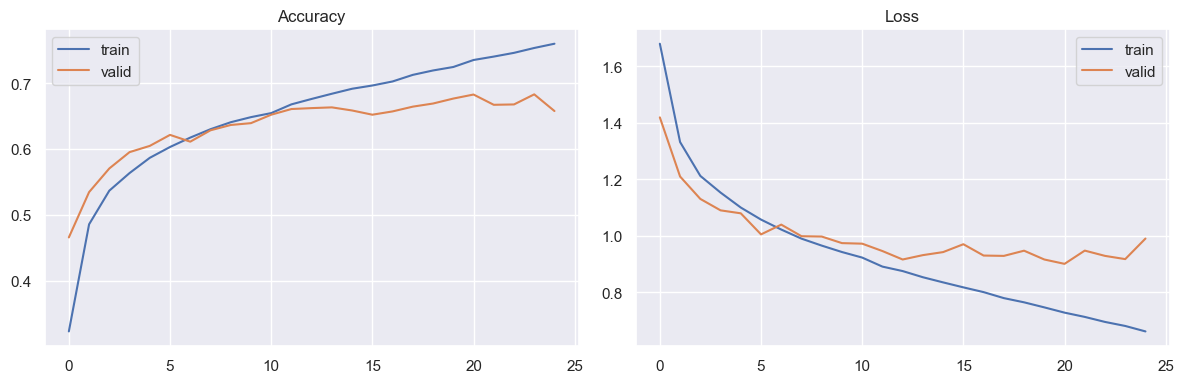

In [101]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn_VGG19_transfer_learning.png')
pyplot.show()

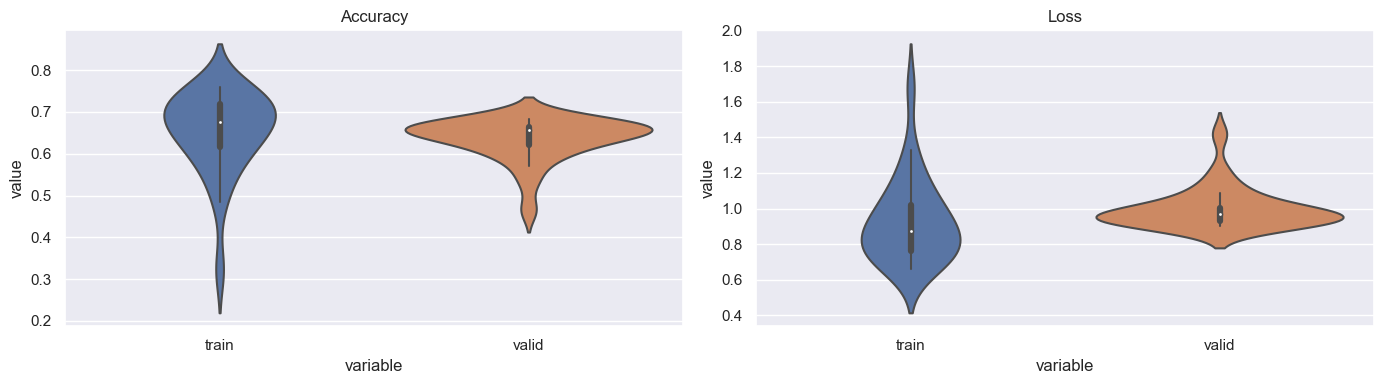

In [102]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

113/113 [==============================] - 1s 8ms/step
total wrong validation predictions: 1229


              precision    recall  f1-score   support

           0       0.54      0.70      0.61       495
           1       0.87      0.60      0.71        55
           2       0.50      0.47      0.49       512
           3       0.90      0.81      0.86       899
           4       0.64      0.38      0.47       608
           5       0.74      0.78      0.76       400
           6       0.56      0.75      0.64       620

    accuracy                           0.66      3589
   macro avg       0.68      0.64      0.65      3589
weighted avg       0.67      0.66      0.65      3589



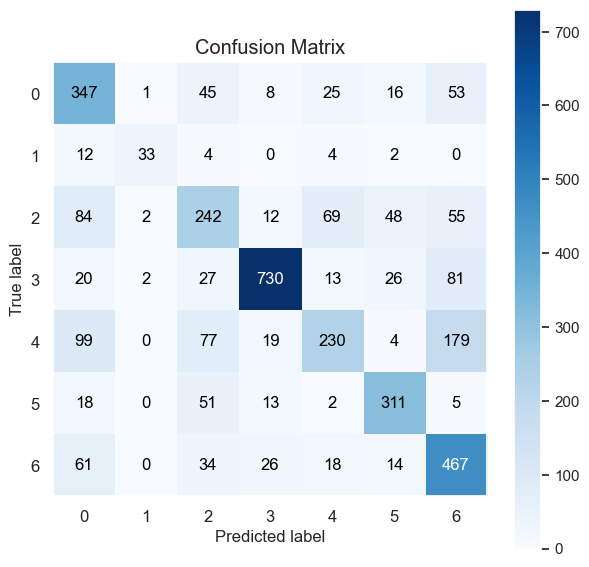

In [103]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

## Mobile netV1

In [104]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [105]:
batch_size= 64
epochs = 50

from keras.callbacks import EarlyStopping, ReduceLROnPlateau


earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop, reduce_lr]

In [106]:
from keras.applications import MobileNet


base_model = MobileNet(weights='imagenet', include_top=False )

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
# and a logistic layer 
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128  

In [112]:
from keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [113]:
def confusion_matrix_img(y_pred, y_true, savename):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    title='Confusion matrix'
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

In [114]:
%%time
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.AUTO),
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='AUC'),f1_score]
)

History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, 
                              callbacks = callbacks,
                              validation_data = (X_valid,y_valid),
                              verbose = 1)

Epoch 1/50


<timed exec>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


505/505 [==============================] - 14s 24ms/step - loss: 1.6913 - accuracy: 0.3592 - precision: 0.5726 - recall: 0.1443 - AUC: 0.7420 - f1_score: 0.2285 - val_loss: 1.4689 - val_accuracy: 0.4291 - val_precision: 0.7307 - val_recall: 0.1950 - val_AUC: 0.8064 - val_f1_score: 0.3043 - lr: 0.0010
Epoch 2/50
505/505 [==============================] - 11s 22ms/step - loss: 1.4078 - accuracy: 0.4642 - precision: 0.7143 - recall: 0.2426 - AUC: 0.8259 - f1_score: 0.3608 - val_loss: 1.3531 - val_accuracy: 0.4909 - val_precision: 0.6267 - val_recall: 0.3700 - val_AUC: 0.8487 - val_f1_score: 0.4618 - lr: 0.0010
Epoch 3/50
505/505 [==============================] - 11s 22ms/step - loss: 1.3143 - accuracy: 0.5042 - precision: 0.7235 - recall: 0.2835 - AUC: 0.8510 - f1_score: 0.4057 - val_loss: 1.2489 - val_accuracy: 0.5238 - val_precision: 0.7182 - val_recall: 0.3394 - val_AUC: 0.8668 - val_f1_score: 0.4574 - lr: 0.0010
Epoch 4/50
505/505 [==============================] - 11s 22ms/step - lo

113/113 [==============================] - 1s 6ms/step
total wrong validation predictions: 1219


              precision    recall  f1-score   support

           0       0.58      0.63      0.61       495
           1       0.60      0.58      0.59        55
           2       0.54      0.37      0.44       512
           3       0.85      0.85      0.85       899
           4       0.55      0.54      0.55       608
           5       0.78      0.70      0.74       400
           6       0.59      0.75      0.66       620

    accuracy                           0.66      3589
   macro avg       0.64      0.63      0.63      3589
weighted avg       0.66      0.66      0.66      3589



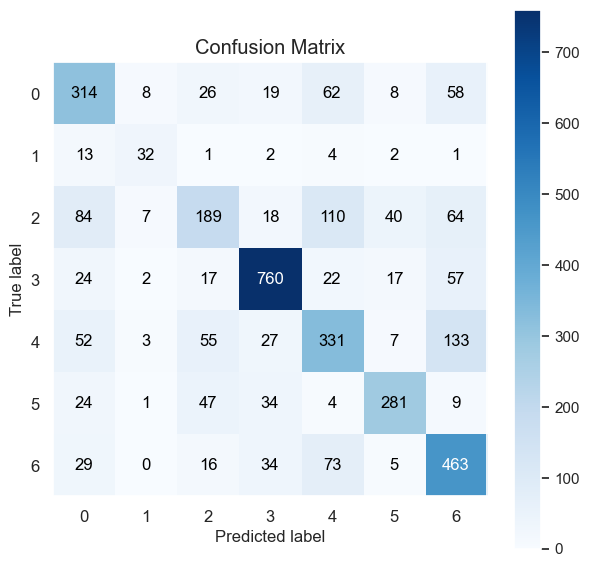

In [115]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [117]:
import matplotlib.pyplot as plt


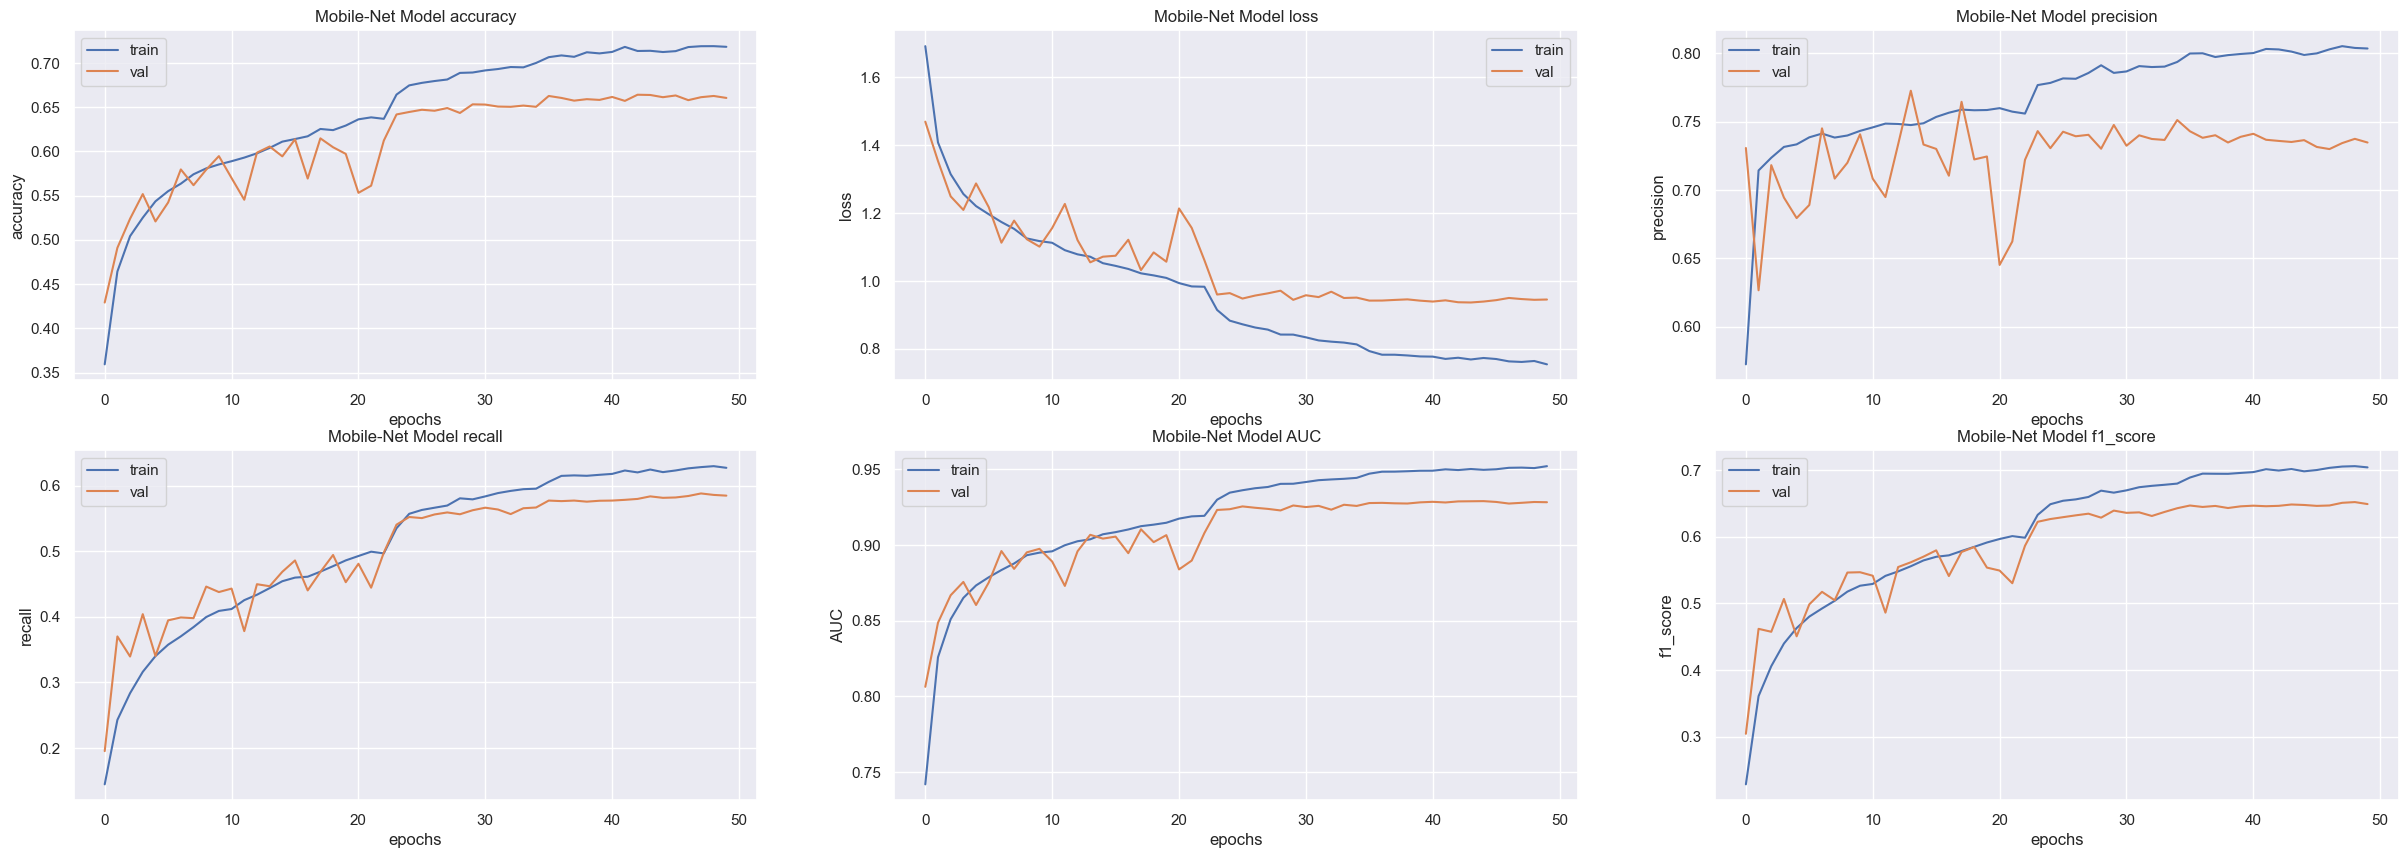

In [118]:
# Interpreting the Metrics
fig, ax = plt.subplots(2, 3, figsize=(30, 10))
ax = ax.ravel()

#for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'AUC', 'f1_score' ]):
    ax[i].plot(History.history[met])
    ax[i].plot(History.history['val_' + met])
    ax[i].set_title('Mobile-Net Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model-plot.png")


## Mobilenetv2

In [119]:
from keras.applications import MobileNetV2  # Import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

base_model = MobileNetV2(weights='imagenet', include_top=False)  # Use MobileNetV2

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_11[0][0]']               
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                             

In [120]:
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss=tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.AUTO),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='AUC'), f1_score]
)

History = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=(X_valid, y_valid),
                              verbose=1)


Epoch 1/50


C:\Users\764883\AppData\Local\Temp\ipykernel_13048\1365290887.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  History = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),


505/505 [==============================] - 16s 27ms/step - loss: 1.7489 - accuracy: 0.3081 - precision: 0.5723 - recall: 0.0726 - AUC: 0.7090 - f1_score: 0.1256 - val_loss: 3.9166 - val_accuracy: 0.1736 - val_precision: 0.1810 - val_recall: 0.1362 - val_AUC: 0.5589 - val_f1_score: 0.1556 - lr: 0.0010
Epoch 2/50
505/505 [==============================] - 12s 25ms/step - loss: 1.5168 - accuracy: 0.4147 - precision: 0.6997 - recall: 0.1814 - AUC: 0.7894 - f1_score: 0.2863 - val_loss: 2.0591 - val_accuracy: 0.3536 - val_precision: 0.4164 - val_recall: 0.2881 - val_AUC: 0.7211 - val_f1_score: 0.3367 - lr: 0.0010
Epoch 3/50
505/505 [==============================] - 12s 24ms/step - loss: 1.4242 - accuracy: 0.4549 - precision: 0.7256 - recall: 0.2274 - AUC: 0.8186 - f1_score: 0.3450 - val_loss: 1.6197 - val_accuracy: 0.4246 - val_precision: 0.5819 - val_recall: 0.2928 - val_AUC: 0.7937 - val_f1_score: 0.3865 - lr: 0.0010
Epoch 4/50
505/505 [==============================] - 12s 25ms/step - lo

## Resnet50

In [28]:
import numpy as np

# # Reshape and normalize
# X = np.array(data['pixels'].str.split(' ').tolist(), dtype='float32').reshape(-1, 48, 48, 1) / 255.0
y = np.array(data['emotion'])


X = np.array(data['pixels'].str.split(' ').tolist(), dtype='float32').reshape(-1, 48, 48, 1) / 255.0
X = np.repeat(X, 3, axis=-1)  # Repeating the grayscale channel 3 times to create a 3-channel image


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


In [34]:
from tensorflow.keras import layers, models


In [35]:
# Step 3: Build Model
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights=None, include_top=False, input_shape=(48, 48, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(7, activation='softmax')(x)
model = models.Model(inputs=base_model.input, outputs=predictions)

In [36]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [37]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10
)


Epoch 1/10
898/898 [==============================] - 847s 930ms/step - loss: 1.8844 - accuracy: 0.2451 - val_loss: 1.8054 - val_accuracy: 0.2459
Epoch 2/10
898/898 [==============================] - 877s 976ms/step - loss: 1.8165 - accuracy: 0.2517 - val_loss: 1.8094 - val_accuracy: 0.2459
Epoch 3/10
898/898 [==============================] - 882s 982ms/step - loss: 1.8043 - accuracy: 0.2515 - val_loss: 1.7804 - val_accuracy: 0.2459
Epoch 4/10
898/898 [==============================] - 881s 981ms/step - loss: 1.8021 - accuracy: 0.2517 - val_loss: 1.7868 - val_accuracy: 0.2459
Epoch 5/10
898/898 [==============================] - 874s 973ms/step - loss: 1.7971 - accuracy: 0.2516 - val_loss: 1.8049 - val_accuracy: 0.2459
Epoch 6/10
898/898 [==============================] - 875s 974ms/step - loss: 1.7931 - accuracy: 0.2516 - val_loss: 1.7808 - val_accuracy: 0.2459
Epoch 7/10
898/898 [==============================] - 875s 974ms/step - loss: 1.8068 - accuracy: 0.2517 - val_loss: 1.8106 -

In [39]:

y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)


225/225 [==============================] - 22s 96ms/step


Confusion Matrix:
[[   0    0    0  985    0    0    0]
 [   0    0    0  102    0    0    0]
 [   0    0    0 1043    0    0    0]
 [   0    0    0 1765    0    0    0]
 [   0    0    0 1210    0    0    0]
 [   0    0    0  795    0    0    0]
 [   0    0    0 1278    0    0    0]]


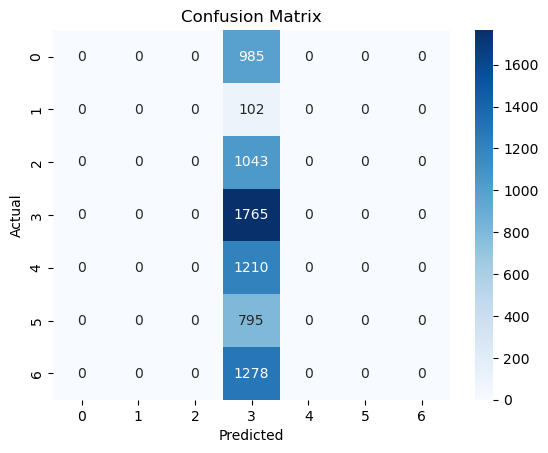

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       985
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00      1043
           3       0.25      1.00      0.39      1765
           4       0.00      0.00      0.00      1210
           5       0.00      0.00      0.00       795
           6       0.00      0.00      0.00      1278

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assume y_pred contains the predicted labels from your model
# and y_test contains the true labels

# Calculating the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Printing the Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Calculating and Printing the Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:",)
print(class_report)


In [ ]:
## resnet 50 approach 2

The key steps are:

Load pretrained ResNet50 without top layers
Freeze base layers
Add custom classification layers
Compile model with SGD optimizer
Generate augmented image data
Train top layers first
Unfreeze lower layers and retrain model
Save fine-tuned model
This allows finetuning the ResNet50 on a custom dataset using transfer learning. The lower level features are reused while the top layers are retrained.

In [41]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder

# Initialize RandomOverSampler
ros = RandomOverSampler()

# Reshape and resample X_train and y_train
X_resampled, y_resampled = ros.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

# Reshape X_resampled back to its original shape
X_resampled = X_resampled.reshape((X_resampled.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]))

# Re-assign the resampled data to X_train
X_train = X_resampled

# If y_train was one-hot encoded, you'll need to one-hot encode y_resampled as well
encoder = OneHotEncoder(sparse=False)
y_resampled = encoder.fit_transform(y_resampled.reshape(-1, 1))

# Re-assign the resampled labels to y_train if needed
y_train = y_resampled



In [45]:
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

# Load ResNet50 model without classifier layers
model = ResNet50(include_top=False, weights='imagenet', 
                 input_shape=(224, 224, 3))

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add custom layers 
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create full model 
model = Model(inputs=model.input, outputs=predictions)

# Compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generate augmented image data
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')



train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Fine tune model 
model.fit_generator(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10)

# Unfreeze layers and retrain
for layer in model.layers[10:]:
    layer.trainable = True

model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=15)

Epoch 1/10


C:\Users\HP\AppData\Local\Temp\ipykernel_21452\3975817772.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


1581/1581 [==============================] - 182s 113ms/step - loss: 1.9628 - accuracy: 0.1582
Epoch 2/10
1581/1581 [==============================] - 168s 106ms/step - loss: 1.9366 - accuracy: 0.1755
Epoch 3/10
1581/1581 [==============================] - 189s 119ms/step - loss: 1.9342 - accuracy: 0.1755
Epoch 4/10
1581/1581 [==============================] - 194s 123ms/step - loss: 1.9312 - accuracy: 0.1804
Epoch 5/10
1581/1581 [==============================] - 193s 122ms/step - loss: 1.9298 - accuracy: 0.1832
Epoch 6/10
1581/1581 [==============================] - 184s 117ms/step - loss: 1.9274 - accuracy: 0.1847
Epoch 7/10
1581/1581 [==============================] - 183s 116ms/step - loss: 1.9272 - accuracy: 0.1841
Epoch 8/10
1581/1581 [==============================] - 182s 115ms/step - loss: 1.9253 - accuracy: 0.1865
Epoch 9/10
1581/1581 [==============================] - 183s 115ms/step - loss: 1.9247 - accuracy: 0.1889
Epoch 10/10
1581/1581 [==============================] - 

C:\Users\HP\AppData\Local\Temp\ipykernel_21452\3975817772.py:54: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


1581/1581 [==============================] - 1226s 773ms/step - loss: 1.7136 - accuracy: 0.3344
Epoch 2/15
1581/1581 [==============================] - 1225s 775ms/step - loss: 1.4483 - accuracy: 0.4458
Epoch 3/15
1581/1581 [==============================] - 1099s 695ms/step - loss: 1.3349 - accuracy: 0.4894
Epoch 4/15
1581/1581 [==============================] - 3690s 2s/step - loss: 1.2595 - accuracy: 0.5216
Epoch 5/15
1581/1581 [==============================] - 1103s 698ms/step - loss: 1.1976 - accuracy: 0.5464
Epoch 6/15
1581/1581 [==============================] - 1249s 790ms/step - loss: 1.1506 - accuracy: 0.5653
Epoch 7/15
1581/1581 [==============================] - 1180s 746ms/step - loss: 1.1135 - accuracy: 0.5774
Epoch 8/15
1581/1581 [==============================] - 1118s 707ms/step - loss: 1.0809 - accuracy: 0.5895
Epoch 9/15
1581/1581 [==============================] - 1136s 718ms/step - loss: 1.0450 - accuracy: 0.6010
Epoch 10/15
1581/1581 [============================

## Resnet 50 after proper preprocessing and fully functional code

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam


In [47]:
data = pd.read_csv("fer2013.csv")

In [48]:
## To transform the dat into apropriate format
pixels = data['pixels'].apply(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))
X = np.array([x for x in pixels])
y = pd.get_dummies(data['emotion']).values


In [49]:
## Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)


In [50]:
## data preprocessing for resnet50
X_train = np.stack([X_train]*3, axis=-1)
X_val = np.stack([X_val]*3, axis=-1)
X_test = np.stack([X_test]*3, axis=-1)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


In [51]:
## Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)


In [52]:
## Initialising the model
base_model = ResNet50(weights='imagenet', include_top=False)


In [53]:
## Adding the custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)


In [54]:
# compiling the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [56]:
## First freezing the layers of the base model and train only the custom layers initially
for layer in base_model.layers:
    layer.trainable = False

# Train the model

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
909/909 [==============================] - 698s 764ms/step - loss: 1.4657 - accuracy: 0.4466 - val_loss: 1.4973 - val_accuracy: 0.4366
Epoch 2/10
909/909 [==============================] - 700s 770ms/step - loss: 1.0648 - accuracy: 0.6038 - val_loss: 1.1286 - val_accuracy: 0.5770
Epoch 3/10
909/909 [==============================] - 739s 813ms/step - loss: 0.8427 - accuracy: 0.6906 - val_loss: 1.1623 - val_accuracy: 0.5915
Epoch 4/10
909/909 [==============================] - 734s 807ms/step - loss: 0.6447 - accuracy: 0.7670 - val_loss: 1.1938 - val_accuracy: 0.6043
Epoch 5/10
909/909 [==============================] - 732s 805ms/step - loss: 0.4637 - accuracy: 0.8361 - val_loss: 1.3540 - val_accuracy: 0.5996
Epoch 6/10
909/909 [==============================] - 727s 800ms/step - loss: 0.3390 - accuracy: 0.8810 - val_loss: 1.4562 - val_accuracy: 0.5982
Epoch 7/10
909/909 [==============================] - 739s 813ms/step - loss: 0.2676 - accuracy: 0.9090 - val_loss: 1.6419 -

In [58]:
## unfreeze some layers and continuing fine tuning
for layer in base_model.layers[:100]:
    layer.trainable = True

# Retrain the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)


Epoch 1/10
909/909 [==============================] - 718s 790ms/step - loss: 0.1509 - accuracy: 0.9493 - val_loss: 1.8346 - val_accuracy: 0.6043
Epoch 2/10
909/909 [==============================] - 1038s 1s/step - loss: 0.1307 - accuracy: 0.9547 - val_loss: 1.9995 - val_accuracy: 0.5985
Epoch 3/10
909/909 [==============================] - 717s 789ms/step - loss: 0.1270 - accuracy: 0.9580 - val_loss: 1.9044 - val_accuracy: 0.6060
Epoch 4/10
909/909 [==============================] - 663s 729ms/step - loss: 0.1193 - accuracy: 0.9600 - val_loss: 1.9802 - val_accuracy: 0.5901
Epoch 5/10
909/909 [==============================] - 647s 712ms/step - loss: 0.1131 - accuracy: 0.9599 - val_loss: 1.9143 - val_accuracy: 0.6199
Epoch 6/10
909/909 [==============================] - 637s 701ms/step - loss: 0.1049 - accuracy: 0.9641 - val_loss: 2.0846 - val_accuracy: 0.6160
Epoch 7/10
909/909 [==============================] - 637s 700ms/step - loss: 0.1052 - accuracy: 0.9631 - val_loss: 2.0393 - v

In [59]:
#evaluating the model performance
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


113/113 [==============================] - 11s 95ms/step - loss: 2.0420 - accuracy: 0.6135
Test Loss: 2.0420167446136475, Test Accuracy: 0.6135413646697998


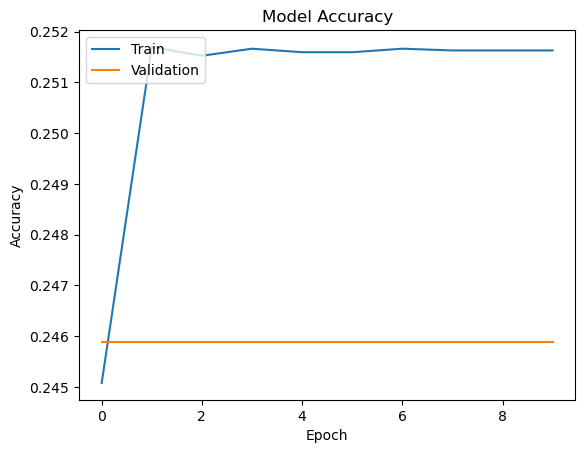

In [63]:
# Plot training history
import matplotlib.pyplot as plt

# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


113/113 [==============================] - 11s 92ms/step


<AxesSubplot:>

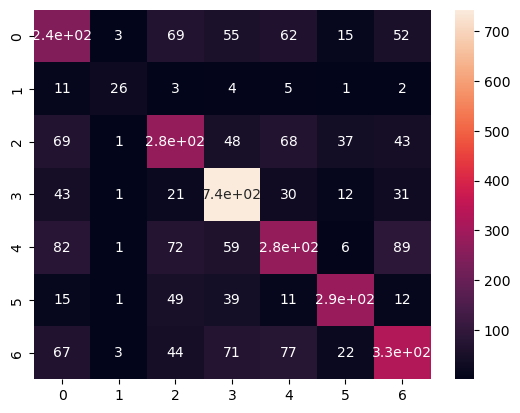

In [64]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True)


In [ ]:
## Advanced matrix

In [65]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall}")
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1}")
print(classification_report(y_true, y_pred))


113/113 [==============================] - 10s 92ms/step
Precision: 0.6049882468022134
Recall: 0.6082474226804123
F1 Score: 0.6046729084897355
              precision    recall  f1-score   support

           0       0.46      0.49      0.47       498
           1       0.72      0.50      0.59        52
           2       0.52      0.51      0.52       545
           3       0.73      0.84      0.78       881
           4       0.52      0.47      0.50       588
           5       0.76      0.69      0.72       414
           6       0.59      0.54      0.56       611

    accuracy                           0.61      3589
   macro avg       0.61      0.58      0.59      3589
weighted avg       0.60      0.61      0.60      3589



## CNN Model

In [123]:
df = pd.read_csv("fer2013.csv")


In [12]:
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [6]:
data = pd.read_csv('fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [7]:
#check usage values
#80% training, 10% validation and 10% test
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [8]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


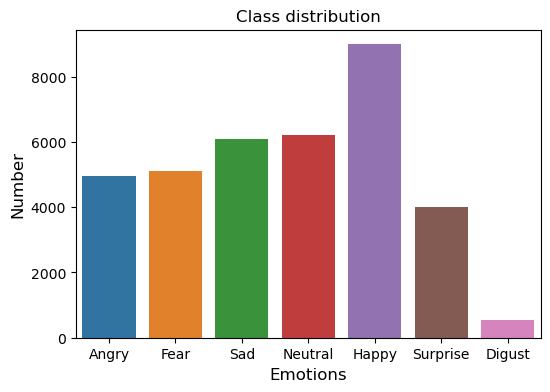

In [9]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_2572\2411459066.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


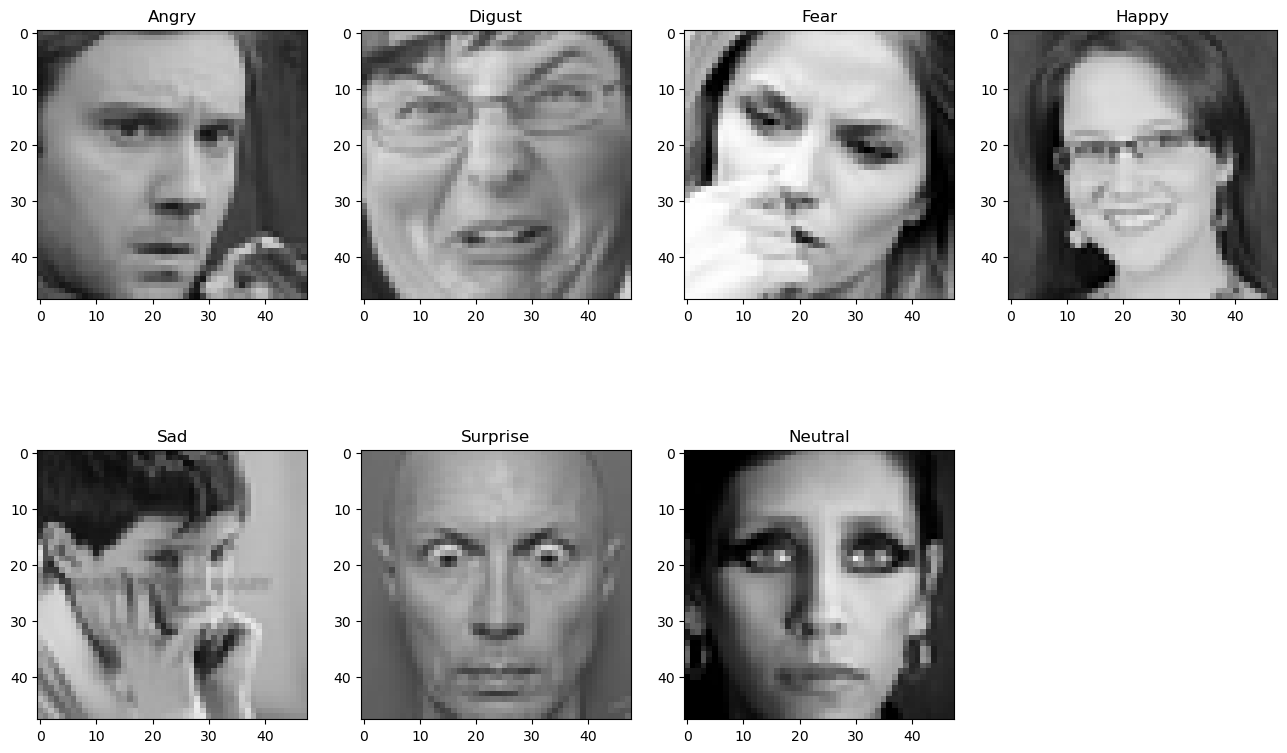

In [13]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

In [14]:
## Preprocessing

In [15]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


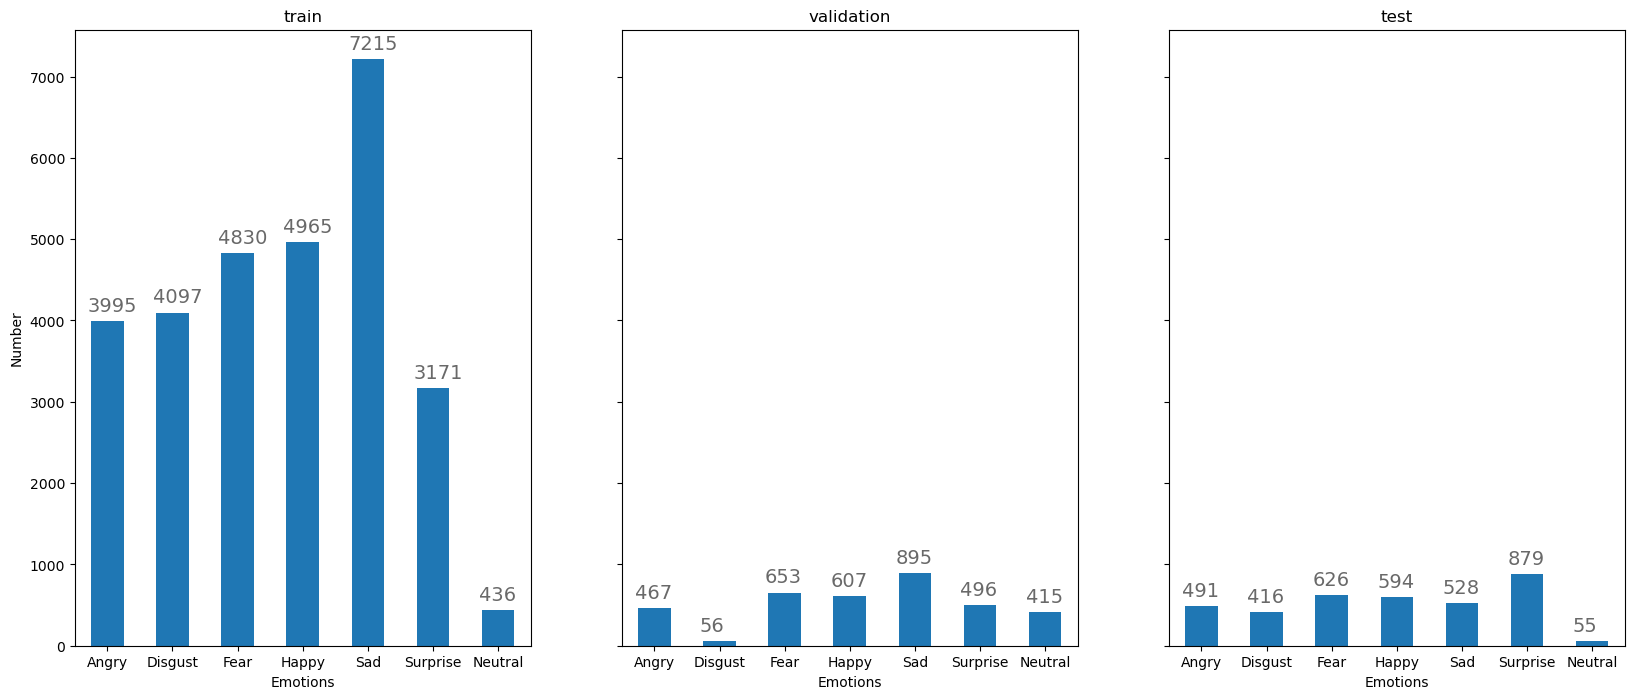

In [16]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [26]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 10
batch_size = 100
num_features = 32

In [18]:

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data


train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [19]:
## Building the CNN model

In [29]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))



#flatten
model.add(Flatten())

# #dense 1
# model.add(Dense(2*2*2*num_features))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 46, 46, 128)       1280      
                                                                 
 batch_normalization_23 (Bat  (None, 46, 46, 128)      512       
 chNormalization)                                                
                                                                 
 activation_23 (Activation)  (None, 46, 46, 128)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 46, 46, 128)       147584    
                                                                 
 batch_normalization_24 (Bat  (None, 46, 46, 128)      512       
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 46, 46, 128)      

In [30]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/10


C:\Users\HP\AppData\Local\Temp\ipykernel_2572\3362797953.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),


287/287 - 460s - loss: 1.6570 - accuracy: 0.3449 - val_loss: 1.7762 - val_accuracy: 0.2758 - 460s/epoch - 2s/step
Epoch 2/10
287/287 - 15517s - loss: 1.4081 - accuracy: 0.4524 - val_loss: 1.5844 - val_accuracy: 0.4040 - 15517s/epoch - 54s/step
Epoch 3/10
287/287 - 436s - loss: 1.3000 - accuracy: 0.5016 - val_loss: 1.3445 - val_accuracy: 0.4901 - 436s/epoch - 2s/step
Epoch 4/10
287/287 - 447s - loss: 1.2254 - accuracy: 0.5323 - val_loss: 1.3126 - val_accuracy: 0.5021 - 447s/epoch - 2s/step
Epoch 5/10
287/287 - 431s - loss: 1.1743 - accuracy: 0.5532 - val_loss: 1.1835 - val_accuracy: 0.5567 - 431s/epoch - 2s/step
Epoch 6/10
287/287 - 429s - loss: 1.1420 - accuracy: 0.5634 - val_loss: 1.3129 - val_accuracy: 0.5143 - 429s/epoch - 1s/step
Epoch 7/10
287/287 - 429s - loss: 1.1125 - accuracy: 0.5765 - val_loss: 1.2056 - val_accuracy: 0.5369 - 429s/epoch - 1s/step
Epoch 8/10
287/287 - 429s - loss: 1.0789 - accuracy: 0.5898 - val_loss: 1.1686 - val_accuracy: 0.5651 - 429s/epoch - 1s/step
Epoch 

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get the model predictions
val_predictions = model.predict(val_X)
val_predictions = np.argmax(val_predictions, axis=1)

# Get true labels
true_labels = np.argmax(val_Y, axis=1)

# Print Classification Report
print("Classification Report:")
print(classification_report(true_labels, val_predictions))

# Print Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(true_labels, val_predictions))


113/113 [==============================] - 11s 100ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.42      0.49       467
           1       0.59      0.18      0.27        56
           2       0.38      0.43      0.40       496
           3       0.80      0.81      0.80       895
           4       0.53      0.31      0.39       653
           5       0.64      0.86      0.73       415
           6       0.49      0.66      0.56       607

    accuracy                           0.59      3589
   macro avg       0.57      0.52      0.52      3589
weighted avg       0.59      0.59      0.57      3589

Confusion Matrix:
[[195   3  97  25  42  23  82]
 [ 12  10  22   1   4   2   5]
 [ 26   1 215  22  67  81  84]
 [ 13   1  30 726  10  39  76]
 [ 57   2 132  71 201  25 165]
 [  5   0  30  11   1 355  13]
 [ 22   0  46  57  51  29 402]]


113/113 [==============================] - 11s 98ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.42      0.49       467
           1       0.59      0.18      0.27        56
           2       0.38      0.43      0.40       496
           3       0.80      0.81      0.80       895
           4       0.53      0.31      0.39       653
           5       0.64      0.86      0.73       415
           6       0.49      0.66      0.56       607

    accuracy                           0.59      3589
   macro avg       0.57      0.52      0.52      3589
weighted avg       0.59      0.59      0.57      3589

Confusion Matrix:
[[195   3  97  25  42  23  82]
 [ 12  10  22   1   4   2   5]
 [ 26   1 215  22  67  81  84]
 [ 13   1  30 726  10  39  76]
 [ 57   2 132  71 201  25 165]
 [  5   0  30  11   1 355  13]
 [ 22   0  46  57  51  29 402]]


<Figure size 800x600 with 0 Axes>

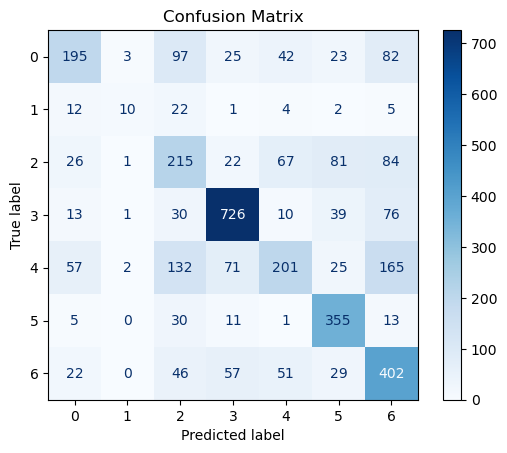

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np



# Get the model predictions
val_predictions = model.predict(val_X)
val_predictions = np.argmax(val_predictions, axis=1)

# Get true labels
true_labels = np.argmax(val_Y, axis=1)

# Print Classification Report
print("Classification Report:")
print(classification_report(true_labels, val_predictions))

# Print Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(true_labels, val_predictions)
print(cm)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


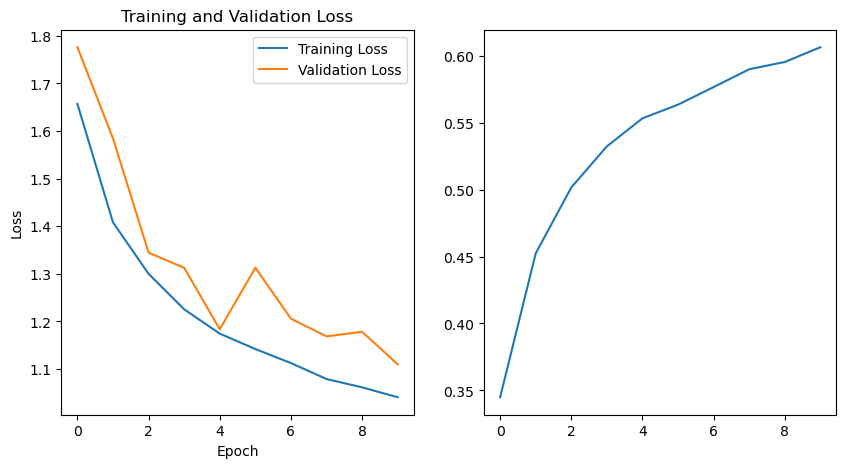

In [34]:
import matplotlib.pyplot as plt



# Plotting the Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Replace 'accuracy' with the name of your accuracy metric


In [ ]:
## CNN model with more layers and more dense layers

In [36]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 46, 46, 128)       1280      
                                                                 
 batch_normalization_29 (Bat  (None, 46, 46, 128)      512       
 chNormalization)                                                
                                                                 
 activation_29 (Activation)  (None, 46, 46, 128)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 46, 46, 128)       147584    
                                                                 
 batch_normalization_30 (Bat  (None, 46, 46, 128)      512       
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 46, 46, 128)      

C:\Users\HP\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [37]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 20
batch_size = 64
num_features = 32

In [38]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/20


C:\Users\HP\AppData\Local\Temp\ipykernel_2572\3362797953.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),


448/448 - 440s - loss: 1.7095 - accuracy: 0.3148 - val_loss: 1.7289 - val_accuracy: 0.2937 - 440s/epoch - 980ms/step
Epoch 2/20
448/448 - 428s - loss: 1.4673 - accuracy: 0.4318 - val_loss: 1.4113 - val_accuracy: 0.4522 - 428s/epoch - 955ms/step
Epoch 3/20
448/448 - 415s - loss: 1.3129 - accuracy: 0.4948 - val_loss: 1.3433 - val_accuracy: 0.4921 - 415s/epoch - 925ms/step
Epoch 4/20
448/448 - 413s - loss: 1.2319 - accuracy: 0.5260 - val_loss: 1.2258 - val_accuracy: 0.5286 - 413s/epoch - 920ms/step
Epoch 5/20
448/448 - 409s - loss: 1.1745 - accuracy: 0.5519 - val_loss: 1.2322 - val_accuracy: 0.5422 - 409s/epoch - 912ms/step
Epoch 6/20
448/448 - 410s - loss: 1.1386 - accuracy: 0.5677 - val_loss: 1.2288 - val_accuracy: 0.5311 - 410s/epoch - 914ms/step
Epoch 7/20
448/448 - 408s - loss: 1.1081 - accuracy: 0.5805 - val_loss: 1.1905 - val_accuracy: 0.5522 - 408s/epoch - 909ms/step
Epoch 8/20
448/448 - 407s - loss: 1.0809 - accuracy: 0.5908 - val_loss: 1.1469 - val_accuracy: 0.5648 - 407s/epoch 

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get the model predictions
val_predictions = model.predict(val_X)
val_predictions = np.argmax(val_predictions, axis=1)

# Get true labels
true_labels = np.argmax(val_Y, axis=1)

# Print Classification Report
print("Classification Report:")
print(classification_report(true_labels, val_predictions))

113/113 [==============================] - 12s 101ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.65      0.56       467
           1       0.59      0.34      0.43        56
           2       0.40      0.45      0.42       496
           3       0.88      0.77      0.82       895
           4       0.52      0.49      0.50       653
           5       0.66      0.78      0.72       415
           6       0.58      0.47      0.52       607

    accuracy                           0.60      3589
   macro avg       0.59      0.56      0.57      3589
weighted avg       0.62      0.60      0.61      3589



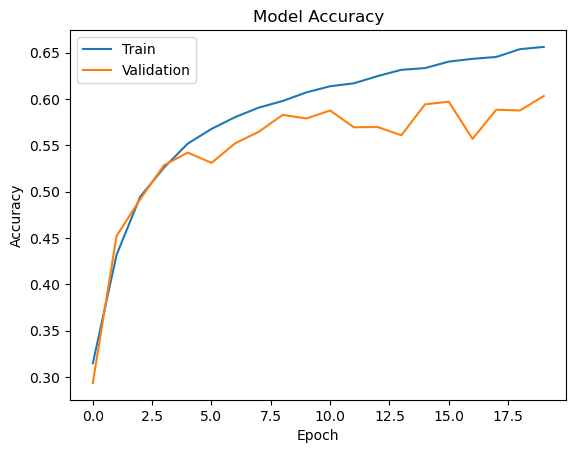

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


<Figure size 800x600 with 0 Axes>

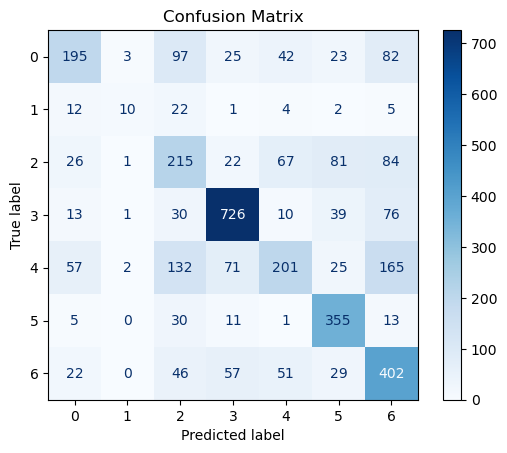

In [41]:
# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


## CNN LSTM model

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np


In [63]:
# Build the CNN model

model = Sequential()

# CNN layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output
model.add(Flatten())


In [64]:

model.add(Reshape((32, int(model.output_shape[1] / 32))))


In [65]:
# Add the LSTM layer
# LSTM layer
model.add(LSTM(50))

# Dropout for regularization
model.add(Dropout(0.2))

# Output layer
model.add(Dense(7, activation='softmax'))  # 7 emotion categories


In [66]:
df = pd.read_csv("fer2013.csv")
## To transform the dat into apropriate format
pixels = data['pixels'].apply(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))
X = np.array([x for x in pixels])
y = pd.get_dummies(data['emotion']).values


In [67]:
## Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)


In [68]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
727/727 [==============================] - 37s 48ms/step - loss: 1.8491 - accuracy: 0.2237 - val_loss: 1.8102 - val_accuracy: 0.2506
Epoch 2/10
727/727 [==============================] - 33s 45ms/step - loss: 1.8263 - accuracy: 0.2376 - val_loss: 1.8109 - val_accuracy: 0.2506
Epoch 3/10
727/727 [==============================] - 32s 44ms/step - loss: 1.8200 - accuracy: 0.2449 - val_loss: 1.8117 - val_accuracy: 0.2506
Epoch 4/10
727/727 [==============================] - 32s 44ms/step - loss: 1.8176 - accuracy: 0.2492 - val_loss: 1.8120 - val_accuracy: 0.2506
Epoch 5/10
727/727 [==============================] - 33s 45ms/step - loss: 1.8163 - accuracy: 0.2501 - val_loss: 1.8114 - val_accuracy: 0.2506
Epoch 6/10
727/727 [==============================] - 32s 44ms/step - loss: 1.8151 - accuracy: 0.2502 - val_loss: 1.8120 - val_accuracy: 0.2506
Epoch 7/10
727/727 [==============================] - 32s 44ms/step - loss: 1.8157 - accuracy: 0.2499 - val_loss: 1.8136 - val_accuracy:

In [69]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get the model predictions
val_predictions = model.predict(X_val)
val_predictions = np.argmax(val_predictions, axis=1)

# Get true labels
true_labels = np.argmax(y_val, axis=1)

# Print Classification Report
print("Classification Report:")
print(classification_report(true_labels, val_predictions))

101/101 [==============================] - 2s 19ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       444
           1       0.00      0.00      0.00        41
           2       0.00      0.00      0.00       463
           3       0.26      1.00      0.41       838
           4       0.00      0.00      0.00       535
           5       0.00      0.00      0.00       355
           6       0.00      0.00      0.00       554

    accuracy                           0.26      3230
   macro avg       0.18      0.14      0.06      3230
weighted avg       0.20      0.26      0.11      3230



C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


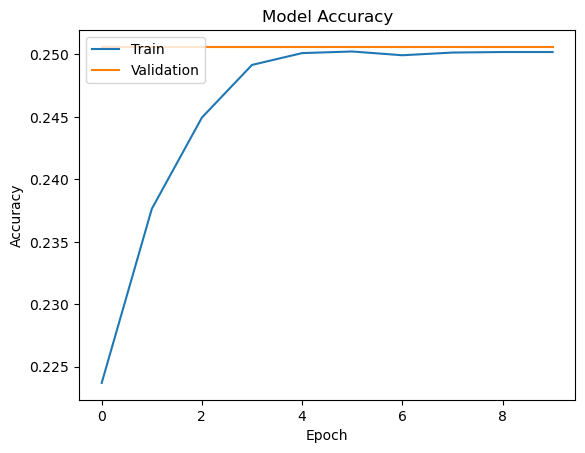

In [70]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


<Figure size 800x600 with 0 Axes>

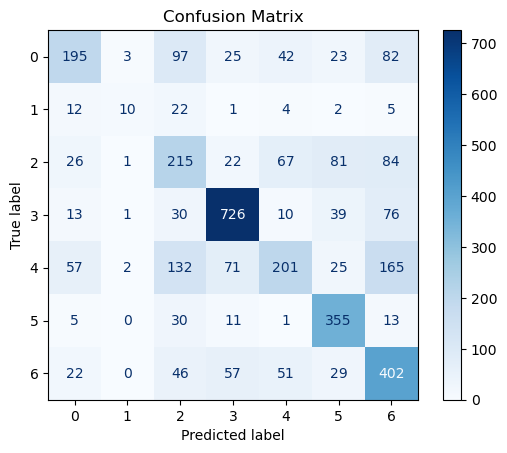

In [74]:
# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [52]:
## Resnet50 LSTM

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam


In [89]:
## To transform the dat into apropriate format
pixels = data['pixels'].apply(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))
X = np.array([x for x in pixels])
y = pd.get_dummies(data['emotion']).values


## Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

## data preprocessing for resnet50
X_train = np.stack([X_train]*3, axis=-1)
X_val = np.stack([X_val]*3, axis=-1)
X_test = np.stack([X_test]*3, axis=-1)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

## Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

## Initialising the model
base_model = ResNet50(weights='imagenet', include_top=False)



# Flatten the output
x = Flatten()(base_model.output)


flattened_dim = 2 * 2 * 2048  

# Choose timesteps such that it divides 8192 evenly
timesteps = 32  
features = flattened_dim // timesteps  

# Now reshape
x = Reshape((timesteps, features))(x)



# Add the LSTM layer
x = LSTM(50)(x)

# Add the output layer (assuming 7 classes for FER)
output = Dense(7, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




In [90]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
727/727 [==============================] - 722s 971ms/step - loss: 1.4634 - accuracy: 0.4393 - val_loss: 1.6055 - val_accuracy: 0.3770
Epoch 2/10
727/727 [==============================] - 741s 1s/step - loss: 1.2473 - accuracy: 0.5300 - val_loss: 1.3955 - val_accuracy: 0.4739
Epoch 3/10
727/727 [==============================] - 738s 1s/step - loss: 1.1510 - accuracy: 0.5658 - val_loss: 1.3336 - val_accuracy: 0.4885
Epoch 4/10
727/727 [==============================] - 734s 1s/step - loss: 1.0642 - accuracy: 0.5984 - val_loss: 1.3536 - val_accuracy: 0.4868
Epoch 5/10
727/727 [==============================] - 735s 1s/step - loss: 0.9839 - accuracy: 0.6312 - val_loss: 1.2300 - val_accuracy: 0.5346
Epoch 6/10
727/727 [==============================] - 736s 1s/step - loss: 0.8998 - accuracy: 0.6680 - val_loss: 1.5001 - val_accuracy: 0.4567
Epoch 7/10
727/727 [==============================] - 740s 1s/step - loss: 0.8026 - accuracy: 0.7067 - val_loss: 1.3019 - val_accuracy: 0.5

In [92]:
# Evaluating the model
# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


113/113 [==============================] - 18s 143ms/step


In [93]:
# classification report
print("Classification Report")
print(classification_report(y_true, y_pred_classes))


Classification Report
              precision    recall  f1-score   support

           0       0.52      0.48      0.50       498
           1       0.43      0.50      0.46        52
           2       0.41      0.38      0.40       545
           3       0.82      0.76      0.79       881
           4       0.44      0.39      0.41       588
           5       0.57      0.74      0.64       414
           6       0.49      0.55      0.52       611

    accuracy                           0.56      3589
   macro avg       0.53      0.54      0.53      3589
weighted avg       0.56      0.56      0.56      3589



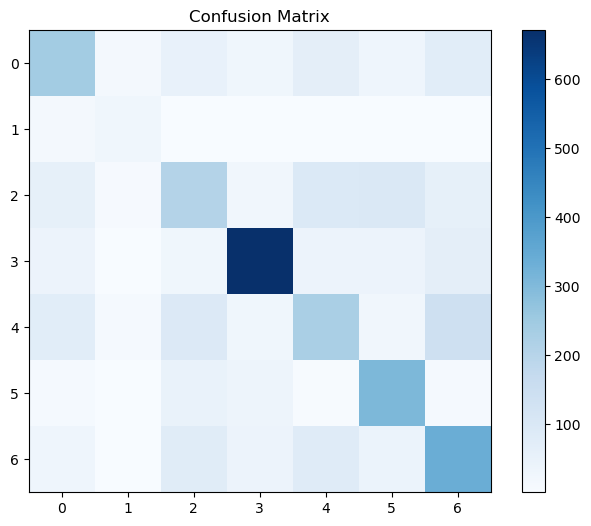

In [94]:
# Confusion matrix
# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()


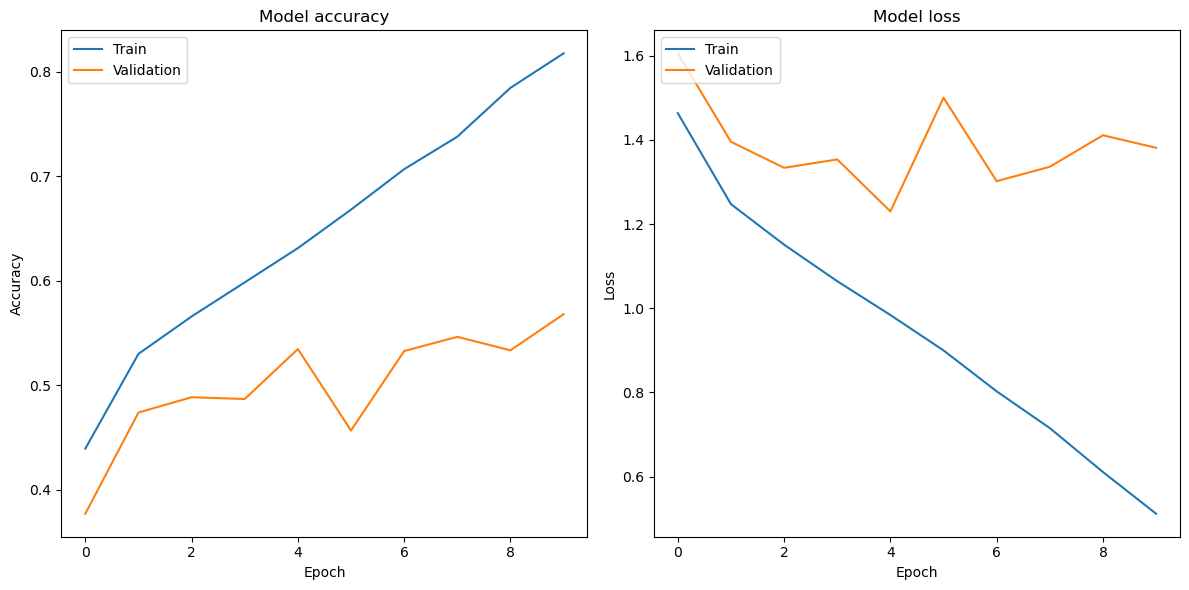

In [95]:
# Train validation graph
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [91]:
# Resnet50 and LSTM model with attention layer, further iterations

In [75]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [98]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Reshape, Flatten, Dense, LSTM, GlobalAveragePooling2D, Multiply, Lambda
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from tensorflow.keras import backend as K

# Your data preprocessing (assuming 'data' is your DataFrame)
pixels = data['pixels'].apply(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))
X = np.array([x for x in pixels])
y = pd.get_dummies(data['emotion']).values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

# Data preprocessing for ResNet50
X_train = np.stack([X_train]*3, axis=-1) / 255.0
X_val = np.stack([X_val]*3, axis=-1) / 255.0
X_test = np.stack([X_test]*3, axis=-1) / 255.0

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

# Initialize the model
base_model = ResNet50(weights='imagenet', include_top=False)

# Add Local Attention to ResNet50
last_conv_layer = base_model.get_layer('conv5_block3_out').output
local_attention = Dense(2048, activation='softmax')(last_conv_layer)
last_conv_layer = Multiply()([last_conv_layer, local_attention])

# Flatten the output
x = Flatten()(last_conv_layer)

# Choose timesteps and features for LSTM input
timesteps = 32
features = 8192 // timesteps

# Reshape for LSTM
x = Reshape((timesteps, features))(x)

# Add LSTM layer
x = LSTM(50, return_sequences=True)(x)

# Add Global Attention to LSTM
def global_attention(x):
    return K.mean(x, axis=1)

x = Lambda(global_attention)(x)

# Add output layer
output = Dense(7, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [100]:
# Train the model
CNN_LSTM_Attention = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
727/727 [==============================] - 830s 1s/step - loss: 1.5500 - accuracy: 0.3885 - val_loss: 1.6263 - val_accuracy: 0.3770
Epoch 2/20
727/727 [==============================] - 779s 1s/step - loss: 1.4495 - accuracy: 0.4381 - val_loss: 1.4872 - val_accuracy: 0.4159
Epoch 3/20
727/727 [==============================] - 808s 1s/step - loss: 1.3939 - accuracy: 0.4611 - val_loss: 1.7280 - val_accuracy: 0.3058
Epoch 4/20
727/727 [==============================] - 813s 1s/step - loss: 1.3951 - accuracy: 0.4607 - val_loss: 1.5055 - val_accuracy: 0.4095
Epoch 5/20
727/727 [==============================] - 816s 1s/step - loss: 1.3322 - accuracy: 0.4914 - val_loss: 1.7381 - val_accuracy: 0.2826
Epoch 6/20
727/727 [==============================] - 818s 1s/step - loss: 1.3334 - accuracy: 0.4914 - val_loss: 1.5358 - val_accuracy: 0.4028
Epoch 7/20
727/727 [==============================] - 820s 1s/step - loss: 1.2615 - accuracy: 0.5171 - val_loss: 1.6158 - val_accuracy: 0.3734

In [101]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


101/101 [==============================] - 31s 289ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.42      0.52      0.46       444
           1       0.50      0.24      0.33        41
           2       0.40      0.33      0.36       463
           3       0.76      0.78      0.77       838
           4       0.43      0.42      0.42       535
           5       0.84      0.54      0.66       355
           6       0.49      0.58      0.53       554

    accuracy                           0.55      3230
   macro avg       0.55      0.49      0.51      3230
weighted avg       0.57      0.55      0.55      3230

Confusion Matrix
[[229   9  48  34  66   3  55]
 [ 17  10   3   0   7   1   3]
 [101   0 152  35  86  30  59]
 [ 53   0  27 657  44   3  54]
 [ 91   1  41  37 226   1 138]
 [ 12   0  87  29   9 193  25]
 [ 44   0  25  70  92   0 323]]


<Figure size 800x600 with 0 Axes>

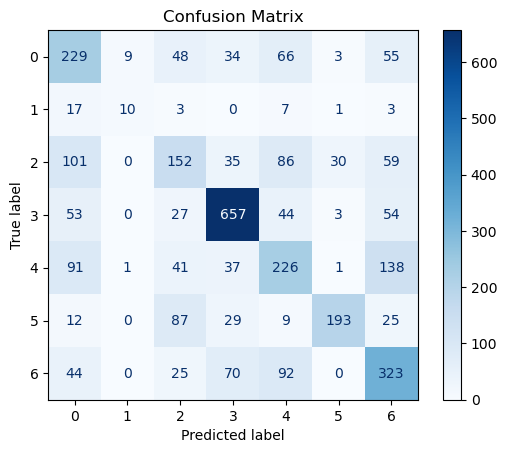

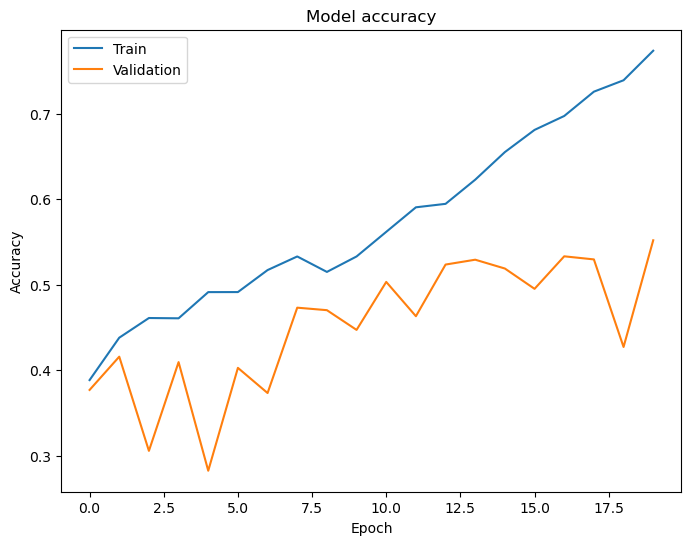

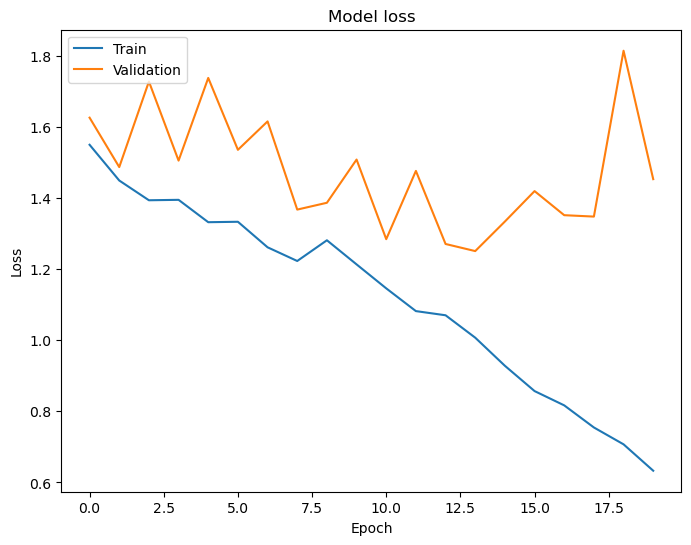

In [102]:
# Predict the values from the validation dataset
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_val, axis=1) 

# Print the Classification Report
print("Classification Report")
print(classification_report(y_true, y_pred_classes))

# Print the Confusion Matrix
print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(CNN_LSTM_Attention.history['accuracy'])
plt.plot(CNN_LSTM_Attention.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(CNN_LSTM_Attention.history['loss'])
plt.plot(CNN_LSTM_Attention.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
